# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 2</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [1841]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp
import sklearn as sk

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


In [1800]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
viviendas_caba_test=pd.read_csv('./Datasets/viviendas_caba_test.csv').copy()
poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 3. Clasificación

### a. Construcción del target

La idea de este Trabajo es poder predecir el precio de una propiedad.  
El tipo de precio puede ser alto, medio o bajo, y para evaluar el mismo vamos a generarnos una nueva variable en el dataset, que sea el precio por metro cuadrado.

In [1801]:
viviendas_caba_train['pxm2'] = viviendas_caba_train.property_price / viviendas_caba_train.property_surface_total
viviendas_caba_test['pxm2'] = viviendas_caba_test.property_price / viviendas_caba_test.property_surface_total
viviendas_caba_train.head()

,Unnamed: 0,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry,pxm2
0,0,2021-11-03,2022-02-02,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.0,65.000000,53.0,198000.0,1 - Holmberg 2700,POINT (-58.4796377 -34.566536),3046.153846
1,1,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,Departamento,1.0,1.0,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,POINT (-58.4594077 -34.6456246),2172.413793
2,2,2021-11-16,2021-11-18,-34.616825,-58.443603,Caballito,Departamento,2.0,1.0,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,POINT (-58.44360306 -34.61682542),2268.292683
3,3,2021-03-08,2021-06-05,-34.577033,-58.423367,Palermo,Departamento,1.0,1.0,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,POINT (-58.4233675 -34.5770327),3265.306122
4,4,2021-01-16,2021-10-09,-34.580210,-58.412815,Palermo,Departamento,1.0,2.0,91.044775,78.0,290000.0,Departamento en Palermo,POINT (-58.412815 -34.58021),3185.245942


Para evaluar el tipo de precio, procedemos a subclasificar el precio por metro cuadrado segun las cantidades de observaciones.  
Primero lo hacemos con cantidad igual de observaciones y luego dividimos en cuartiles , el primero con el 25% de las observaciones, el siguiente con el 50% y el último con el 25% de las observaciones restantes.  
Finalmente selecionaremos cada tipo de propiedad y haremos las mismas divisiones mencionadas.

In [1802]:
labels=["Bajo","Medio","Alto"]

viviendas_caba_train["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train["pxm2"],q=3, labels=labels)
viviendas_caba_train["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train["pxm2"],q=[0,0.25,0.75,1], labels=labels)
viviendas_agrupada_tipo_precio_igual_frec = viviendas_caba_train.groupby(["tipo_precio_igual_frec"]).count()
viviendas_agrupada_tipo_precio_25_50_25 = viviendas_caba_train.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_depto = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="Departamento"]
viviendas_caba_train_depto["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=3, labels=labels)
viviendas_caba_train_depto["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=[0,0.25,0.75,1], labels=labels)
deptos_agrupado_tipo_precio_igual_frec = viviendas_caba_train_depto.groupby(["tipo_precio_igual_frec"]).count()
deptos_agrupado_tipo_precio_25_50_25 = viviendas_caba_train_depto.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_ph = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="PH"]
viviendas_caba_train_ph["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_ph["pxm2"],q=3, labels=labels)
viviendas_caba_train_ph["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_ph["pxm2"],q=[0,0.25,0.75,1], labels=labels)
ph_agrupado_tipo_precio_igual_frec = viviendas_caba_train_ph.groupby(["tipo_precio_igual_frec"]).count()
ph_agrupado_tipo_precio_25_50_25 = viviendas_caba_train_ph.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_casa = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="Casa"]
viviendas_caba_train_casa["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_casa["pxm2"],q=3, labels=labels)
viviendas_caba_train_casa["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_casa["pxm2"],q=[0,0.25,0.75,1], labels=labels)
casas_agrupada_tipo_precio_igual_frec = viviendas_caba_train_casa.groupby(["tipo_precio_igual_frec"]).count()
casas_agrupada_tipo_precio_25_50_25 = viviendas_caba_train_casa.groupby(["tipo_precio_25_50_25"]).count()


C:\Users\forte\AppData\Local\Temp\ipykernel_34308\719687703.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_caba_train_depto["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=3, labels=labels)
C:\Users\forte\AppData\Local\Temp\ipykernel_34308\719687703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_caba_train_depto["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=[0,0.25,0.75,1], labels=labels)
C:\Users\forte\AppData\Local\Temp\ipyke

Y ahora graficamos segun los intervalos obtenidos

[Text(0.5, 1.0, 'Intervalos de viviendas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

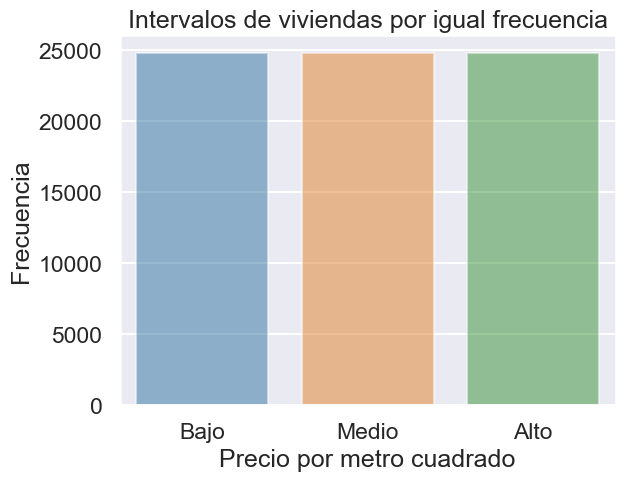

In [1803]:
eje_x = viviendas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de viviendas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de viviendas por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

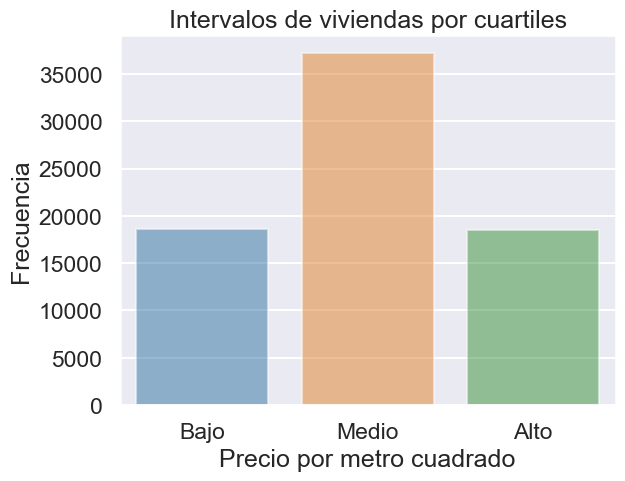

In [1804]:
eje_x = viviendas_agrupada_tipo_precio_25_50_25.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de viviendas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

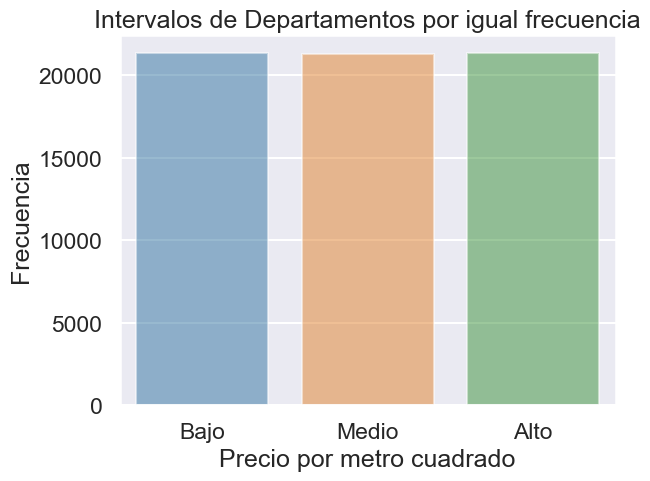

In [1805]:
eje_x = deptos_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = deptos_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Departamentos por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

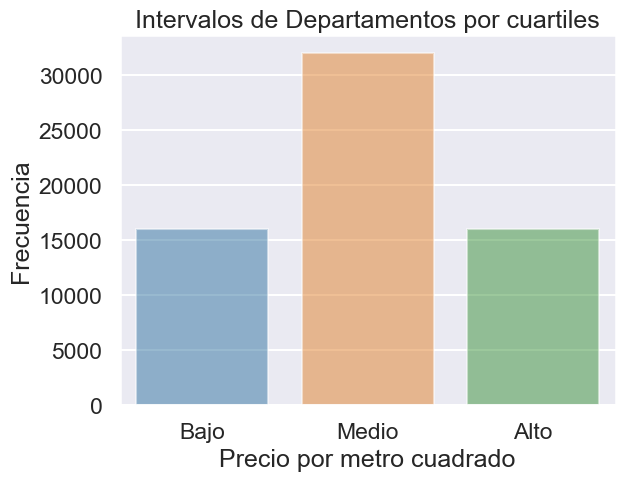

In [1806]:
eje_x = deptos_agrupado_tipo_precio_25_50_25.index.tolist()
eje_y = deptos_agrupado_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de Departamentos por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de PH por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

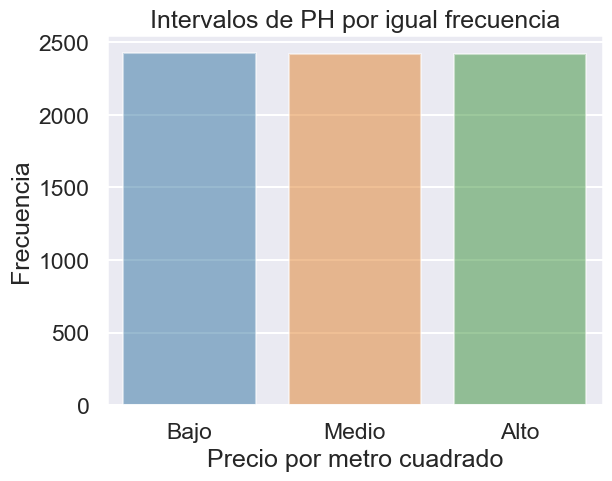

In [1807]:
eje_x = ph_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = ph_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de PH por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')


[Text(0.5, 1.0, 'Intervalos de PH por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

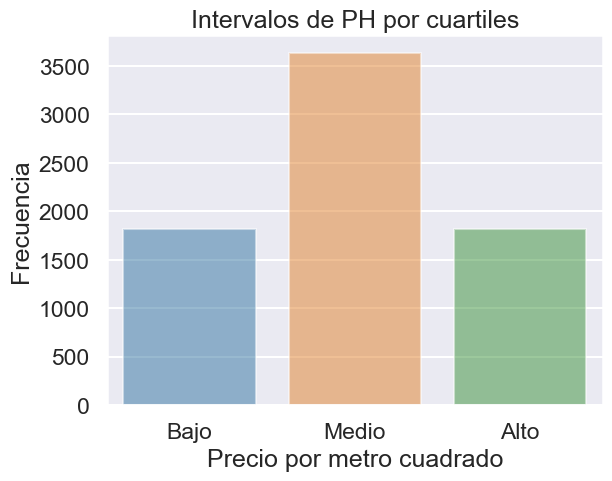

In [1808]:
eje_x = ph_agrupado_tipo_precio_25_50_25.index.tolist()
eje_y = ph_agrupado_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de PH por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Casas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

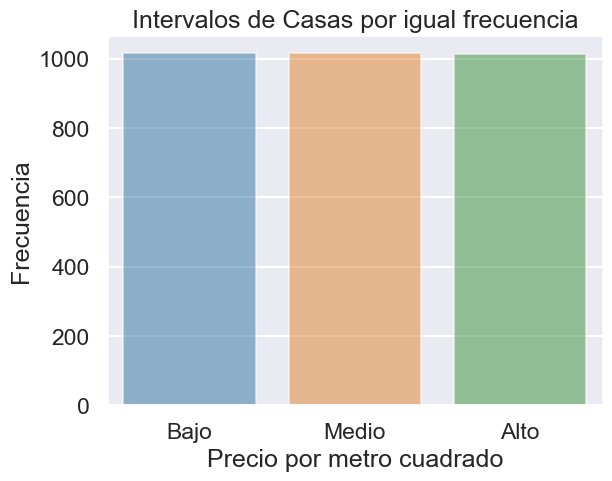

In [1809]:
eje_x = casas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = casas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Casas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')



[Text(0.5, 1.0, 'Intervalos de Casas por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

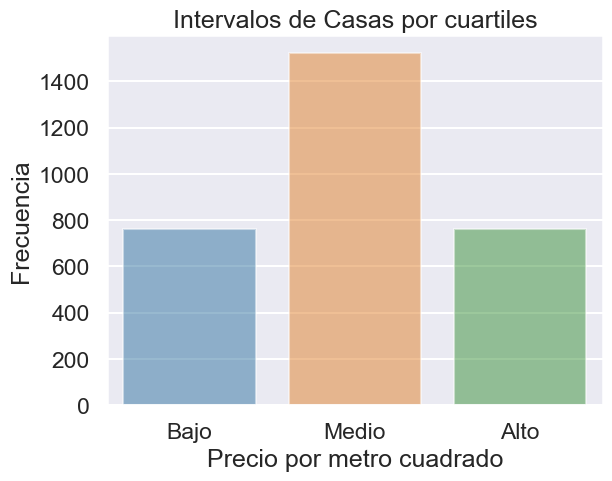

In [1810]:
eje_x = casas_agrupada_tipo_precio_25_50_25.index.tolist()
eje_y = casas_agrupada_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de Casas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

Para darnos una idea del target, vamos a mostrar la distribución del precio de las viviendas de todo el dataset.


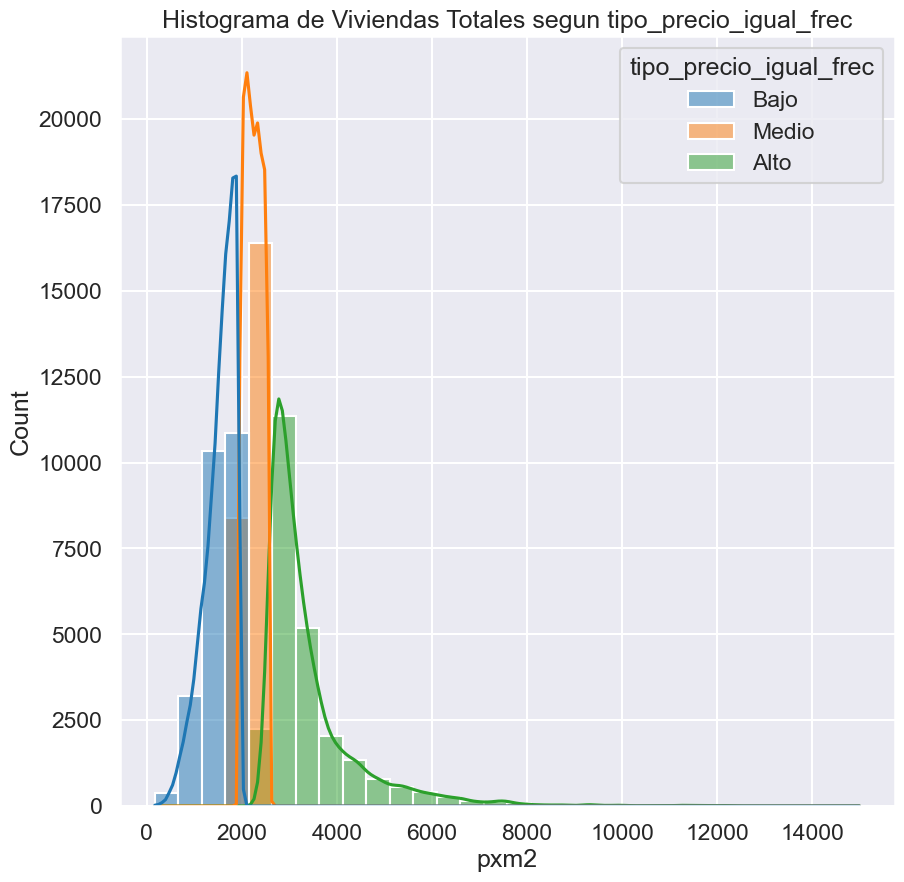

In [1811]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Viviendas Totales segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

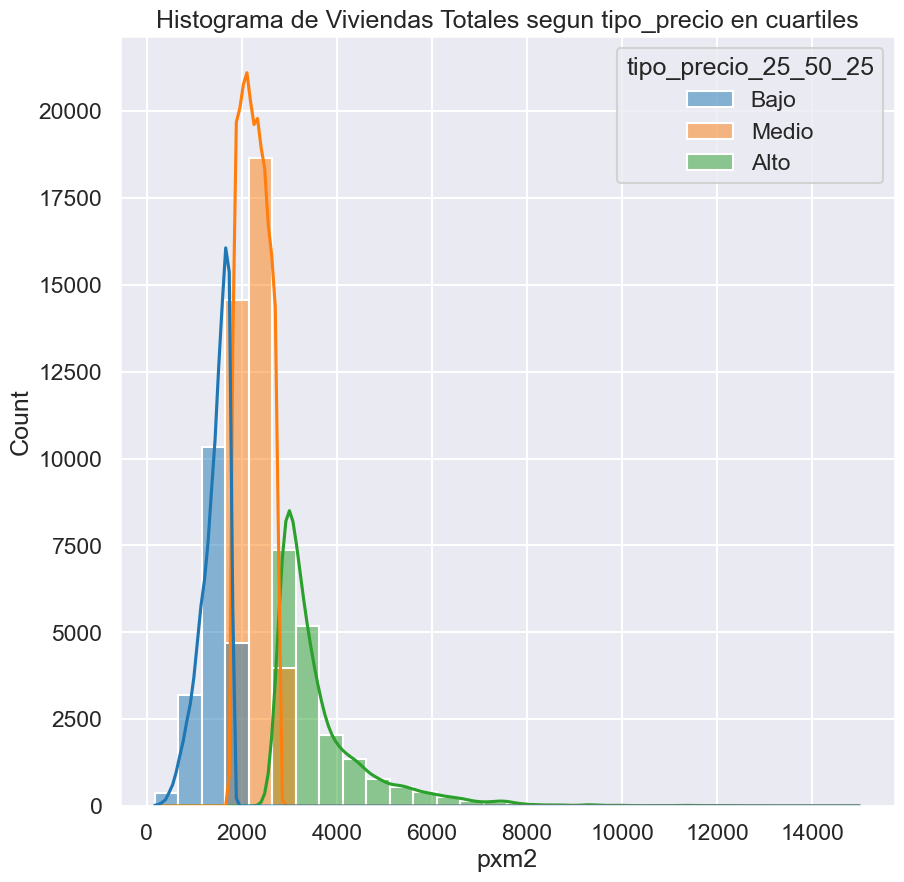

In [1812]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Viviendas Totales segun tipo_precio en cuartiles')
sns.histplot(data = viviendas_caba_train, x ='pxm2', hue = 'tipo_precio_25_50_25', bins=30, kde=True)
plt.show()

Ahora vamos a hacer lo mismo para cada tipo de propiedad

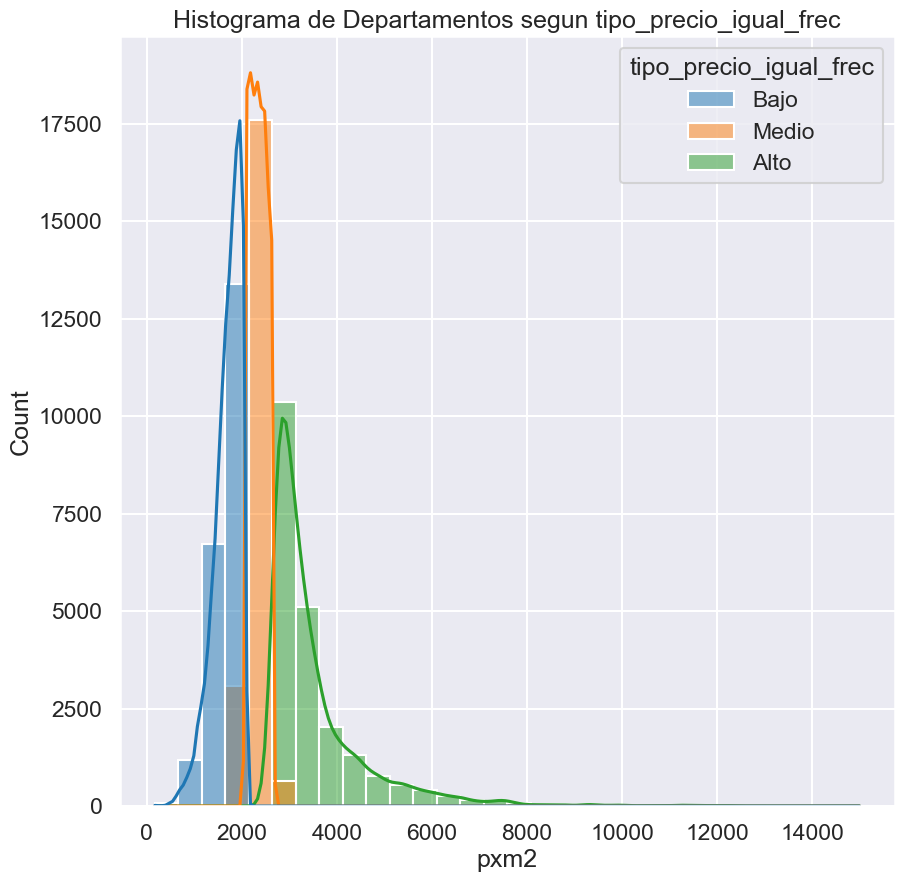

In [1813]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Departamentos segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_depto, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

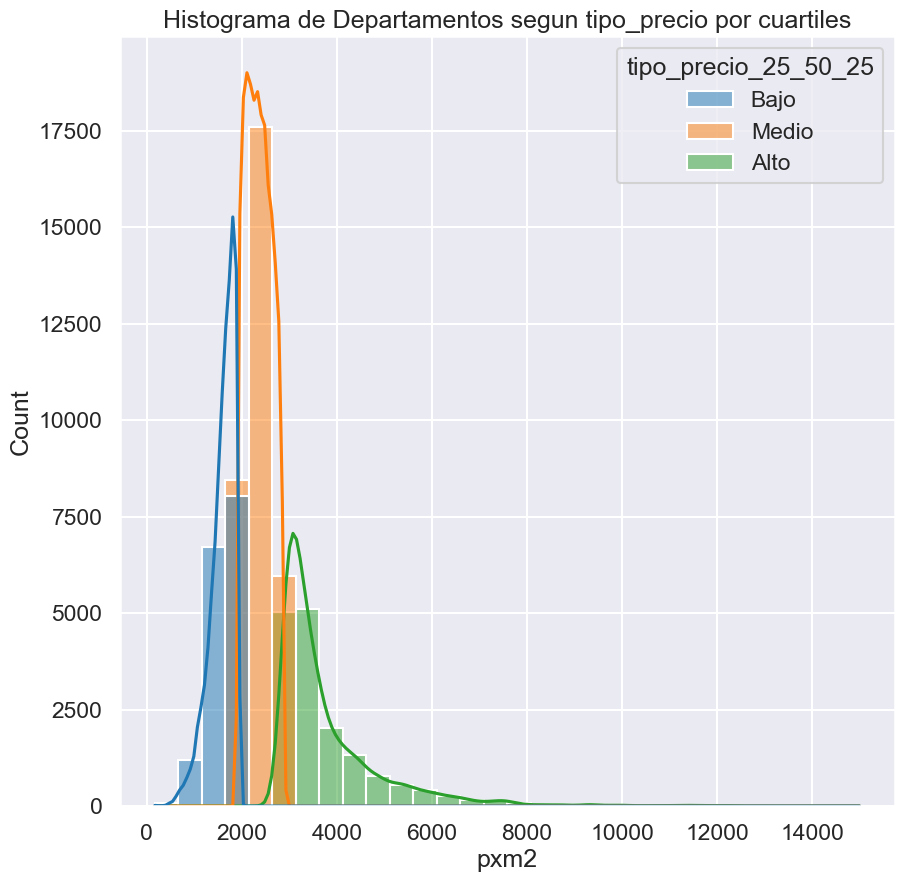

In [1814]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Departamentos segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_depto, x ='pxm2', hue = 'tipo_precio_25_50_25', bins=30, kde=True)
plt.show()

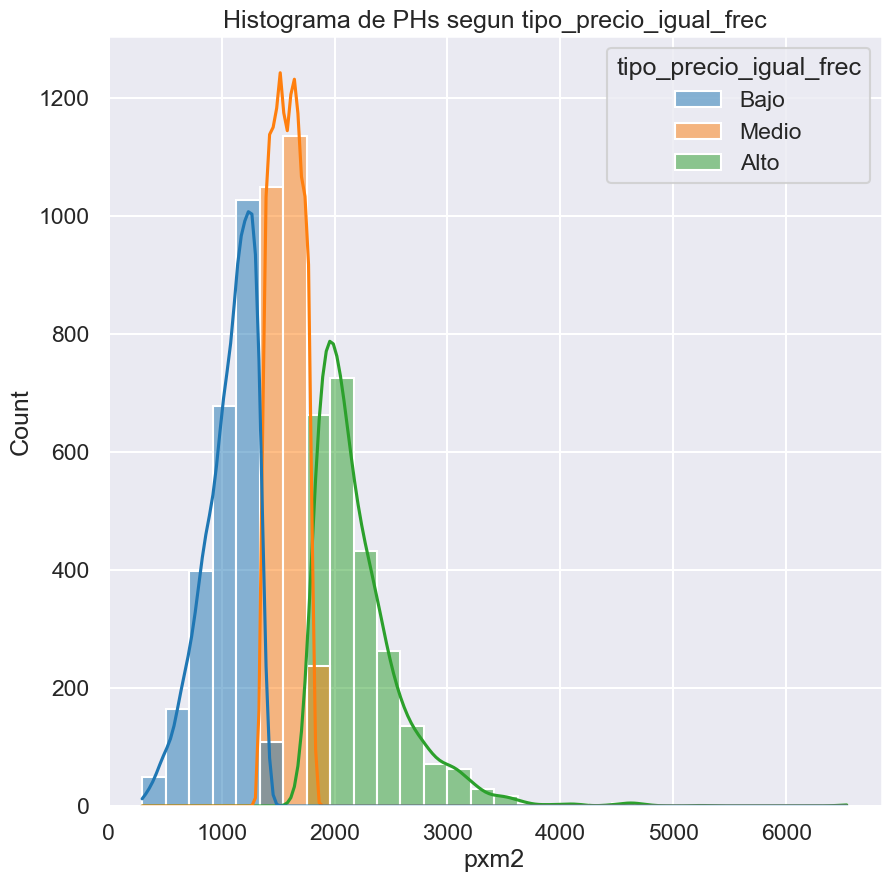

In [1815]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de PHs segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_ph, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

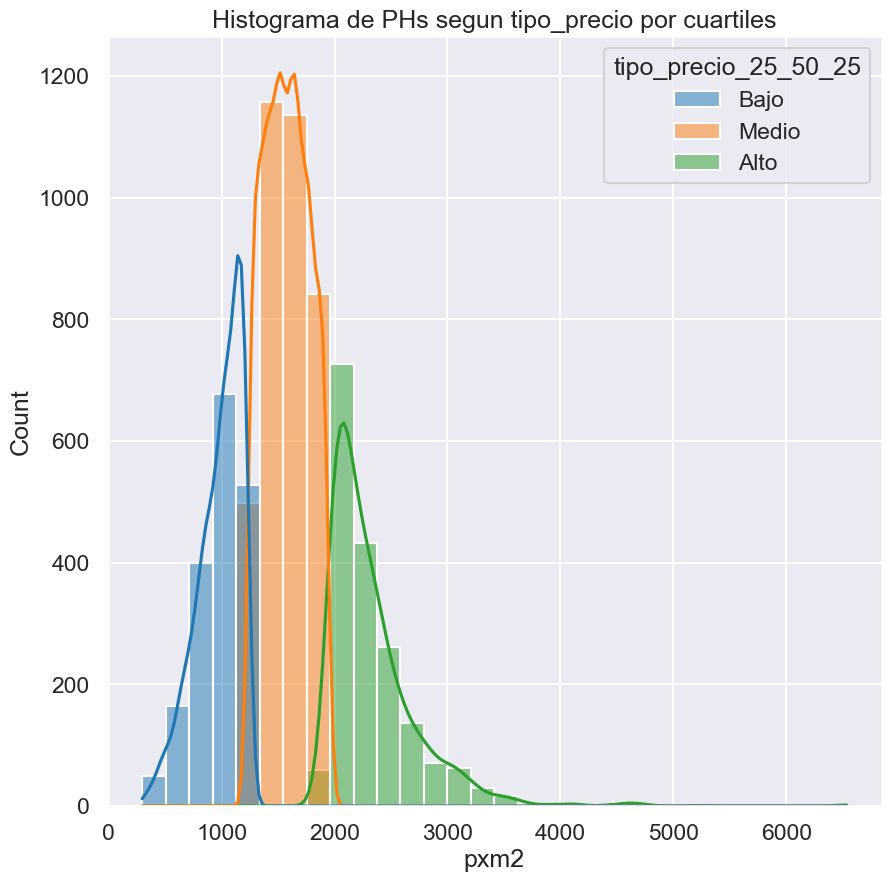

In [1816]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de PHs segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_ph, x ='pxm2', hue = 'tipo_precio_25_50_25', bins=30, kde=True)
plt.show()

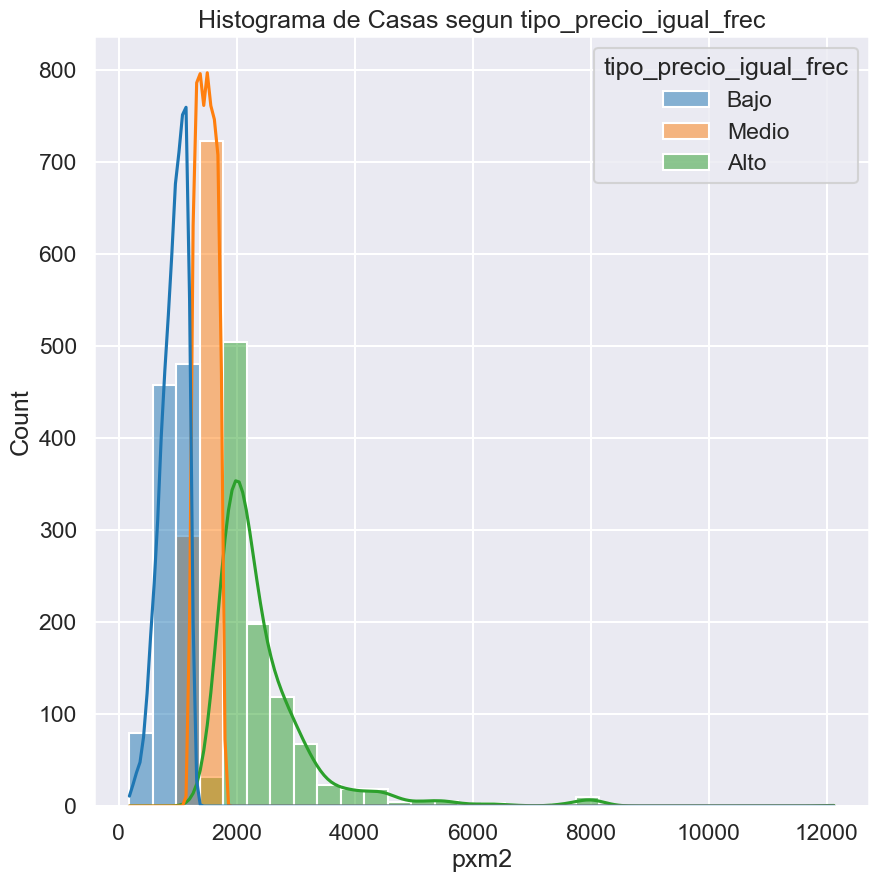

In [1817]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Casas segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_casa, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

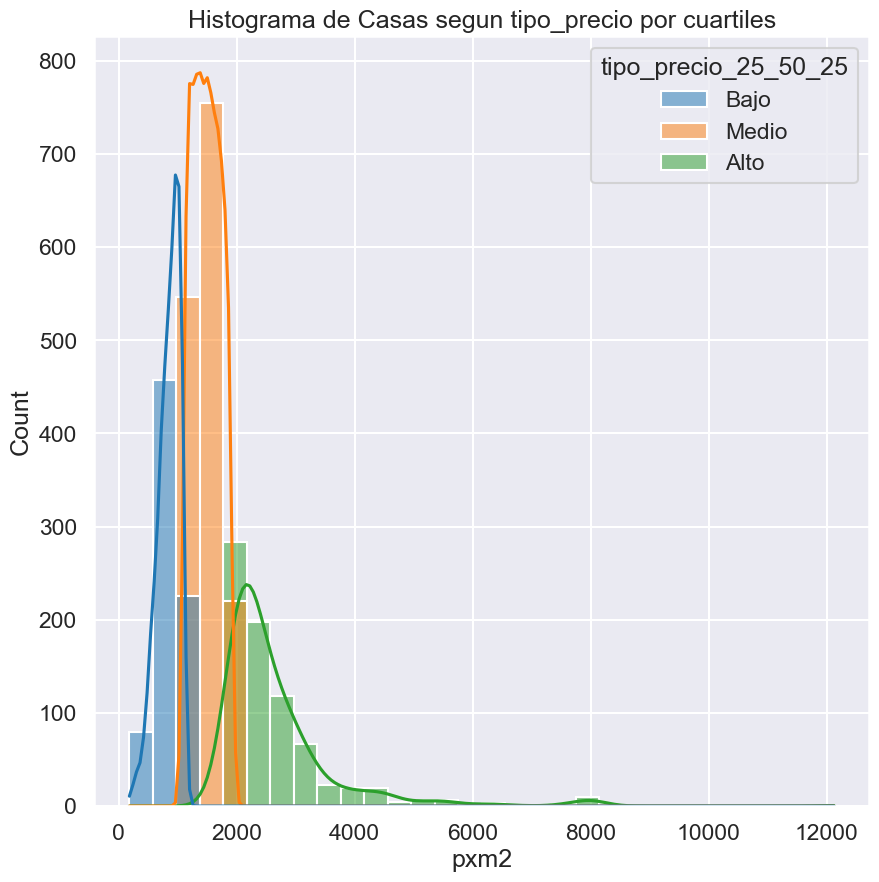

In [1818]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Casas segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_casa, x ='pxm2', hue = 'tipo_precio_25_50_25', bins=30, kde=True)
plt.show()

De los graficos anteriores podemos concluir:
+ Hay muchos mas Departamentos que Casas o PHs, por lo cual vamos a predecir teniendo en cuenta el tipo de propiedad.
+ Por los precios vistos, si dividimos por cuartiles la tendencia a predecir departamentos va a ser fuertemente de tipo 'medio', por la cantidad y por los precios que se pueden ver en los graficos.
+ Por lo anterior, decidimos utilizar el binning de misma frecuencia de datos.

Procedemos a agregar estos datos en los datasets de entrenamiento y prueba.

In [1819]:
viviendas_caba_train.loc[viviendas_caba_train_depto.index,"tipo_precio"] = viviendas_caba_train_depto["tipo_precio_igual_frec"] 
viviendas_caba_train.loc[viviendas_caba_train_ph.index,"tipo_precio"] = viviendas_caba_train_ph["tipo_precio_igual_frec"] 
viviendas_caba_train.loc[viviendas_caba_train_casa.index,"tipo_precio"] = viviendas_caba_train_casa["tipo_precio_igual_frec"] 

viviendas_caba_test_depto = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="Departamento"]
viviendas_caba_test_depto["tipo_precio"] = pd.qcut(viviendas_caba_test_depto["pxm2"],q=3, labels=labels)

viviendas_caba_test_ph = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="PH"]
viviendas_caba_test_ph["tipo_precio"] = pd.qcut(viviendas_caba_test_ph["pxm2"],q=3, labels=labels)

viviendas_caba_test_casa = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="Casa"]
viviendas_caba_test_casa["tipo_precio"] = pd.qcut(viviendas_caba_test_casa["pxm2"],q=3, labels=labels)

viviendas_caba_test.loc[viviendas_caba_test_depto.index,"tipo_precio"] = viviendas_caba_test_depto["tipo_precio"] 
viviendas_caba_test.loc[viviendas_caba_test_ph.index,"tipo_precio"] = viviendas_caba_test_ph["tipo_precio"] 
viviendas_caba_test.loc[viviendas_caba_test_casa.index,"tipo_precio"] = viviendas_caba_test_casa["tipo_precio"] 



viviendas_caba_train.drop(columns=['tipo_precio_igual_frec', 'tipo_precio_25_50_25'], axis = 0, inplace=True)



C:\Users\forte\AppData\Local\Temp\ipykernel_34308\655144138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_caba_test_depto["tipo_precio"] = pd.qcut(viviendas_caba_test_depto["pxm2"],q=3, labels=labels)
C:\Users\forte\AppData\Local\Temp\ipykernel_34308\655144138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_caba_test_ph["tipo_precio"] = pd.qcut(viviendas_caba_test_ph["pxm2"],q=3, labels=labels)
C:\Users\forte\AppData\Local\Temp\ipykernel_34308\655144138.py:12: SettingWithCopyWa

Ahora vamos a ver como se distribuyen las propiedades segun su tipo de precio en CABA.

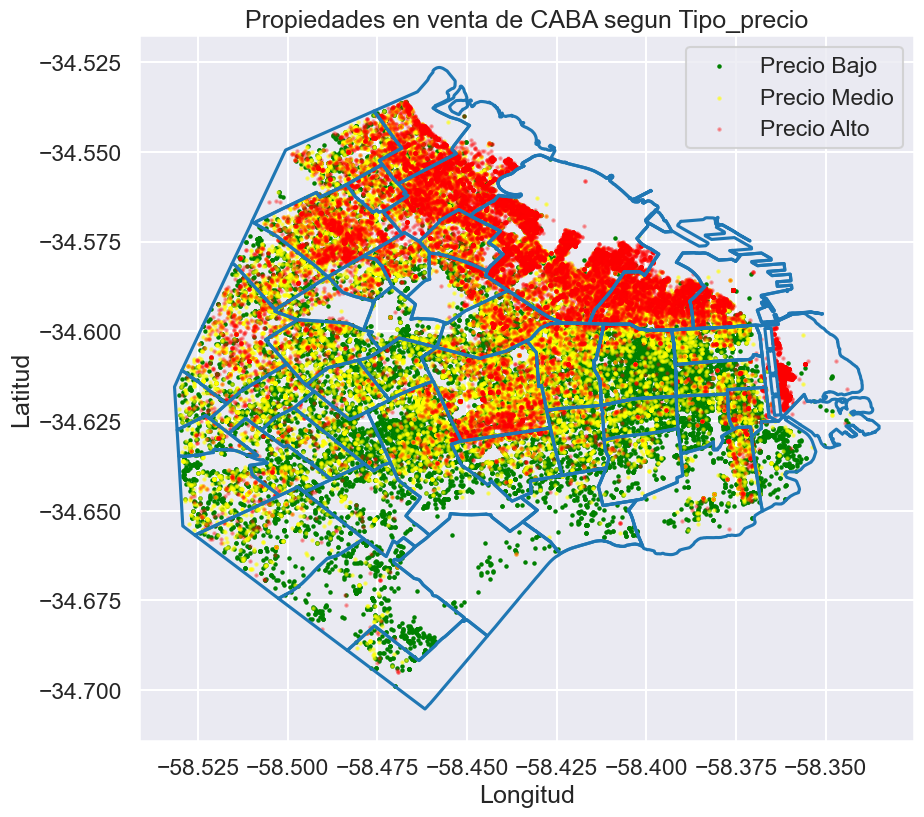

In [1820]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Propiedades en venta de CABA segun Tipo_precio')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
poly.boundary.plot(ax=ax) #CABA
viviendas_caba_train_bajo = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Bajo']
viviendas_caba_train_medio = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Medio']
viviendas_caba_train_alto = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Alto']
puntos_precio_bajo = gp.GeoDataFrame(viviendas_caba_train_bajo, geometry=gp.points_from_xy(viviendas_caba_train_bajo.longitud,viviendas_caba_train_bajo.latitud)) 
puntos_precio_medio = gp.GeoDataFrame(viviendas_caba_train_medio, geometry=gp.points_from_xy(viviendas_caba_train_medio.longitud,viviendas_caba_train_medio.latitud)) 
puntos_precio_alto = gp.GeoDataFrame(viviendas_caba_train_alto, geometry=gp.points_from_xy(viviendas_caba_train_alto.longitud,viviendas_caba_train_alto.latitud)) 
puntos_precio_bajo.plot(ax=ax,markersize=3, label = 'Precio Bajo', color="green")
puntos_precio_medio.plot(ax=ax,markersize=3, label = 'Precio Medio', color="yellow", alpha = 0.5)
puntos_precio_alto.plot(ax=ax,markersize=3,label = 'Precio Alto', color="red", alpha=0.3)
plt.legend()

Se puede observar que en los barrios pertenecientes a la zona norte tienen mucha mas densidad de propiedades, lo cual tiene sentido dado que constantemente se esta construyendo en esos lugares.  
A su vez, en la zona meridional y sur hay menos propiedades en venta pero a mejor precio.  
Puerto Madero tiene mucha gente con plata pero parece que hay propiedades en la reserva ecologica.

## b. Entrenamiento y predicción

Vamos a entrenar modelos para intentar predecir el tipo de precio de un set de propiedades y tambien vamos corroborar la eficiencia de los mismos.  
Antes de ello, vamos a hacer una serie de transformaciones de los dataset.

In [1821]:
ds_modelos = viviendas_caba_train.copy()
columnas_train = ['Unnamed: 0','start_date','end_date','property_price','property_title','geometry','pxm2']
ds_modelos['property_rooms'] = ds_modelos['property_rooms'].astype(int)
ds_modelos['property_bedrooms'] = ds_modelos['property_bedrooms'].astype(int)
ds_modelos['property_surface_total'] = ds_modelos['property_surface_total'].astype(int)
ds_modelos['property_surface_covered'] = ds_modelos['property_surface_covered'].astype(int)
ds_modelos.drop(columns=columnas_train, axis='columns', inplace=True)
ds_modelos.head()

,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,tipo_precio
0,-34.566536,-58.479638,Coghlan,Departamento,2,1,65,53,Alto
1,-34.645625,-58.459408,Flores,Departamento,1,1,29,29,Medio
2,-34.616825,-58.443603,Caballito,Departamento,2,1,41,35,Medio
3,-34.577033,-58.423367,Palermo,Departamento,1,1,49,44,Alto
4,-34.580210,-58.412815,Palermo,Departamento,1,2,91,78,Alto


Corroboramos que la distribución de clases en los datasets sea la misma que la de la alternativa elegida en el punto 3.a).

In [1822]:
ds_modelos['tipo_precio'].value_counts(normalize=True)*100

Bajo     33.368767
Alto     33.328400
Medio    33.302834
Name: tipo_precio, dtype: float64

In [1823]:
viviendas_caba_test['tipo_precio'].value_counts(normalize=True)*100

Medio    33.549469
Bajo     33.342650
Alto     33.107881
Name: tipo_precio, dtype: float64

In [1824]:
columnas_test = ['Unnamed: 0','start_date','end_date','vecindad','property_price','property_title','pxm2']
viviendas_caba_test.drop(columns=columnas_test, axis='columns', inplace=True)

A los fines de poder utilizar el arbol de decision, vamos a sacar del dataset de test aquellas filas con valores NaN.

In [1825]:
viviendas_caba_test.dropna(inplace=True)

Vamos a crear variables dummies para `barrio` y `property_type` y a separar X de Y.

In [1826]:
ds_modelos = pd.get_dummies(ds_modelos, columns=['property_type', 'barrio'])
viviendas_caba_test = pd.get_dummies(viviendas_caba_test, columns=['property_type', 'barrio'])

y_train = ds_modelos['tipo_precio'].copy()
y_test = viviendas_caba_test['tipo_precio'].copy()
x_train = ds_modelos.drop(columns=['tipo_precio'], axis='columns', inplace=False)
x_test = viviendas_caba_test.drop(columns=['tipo_precio'], axis='columns', inplace=False)


### Modelo 1: Arbol de decisión

Para el modelo de arbol, vamos a buscar la mejor combinacion de hiperparametros utilizando K-fold Cross Validation y buscando los mismos con Random Search.  
Primero veremos de encontrar la cantidad de folds optima para este caso y luego veremos si podemos mejorar la busqueda de parametros utilizando Grid Search.  
Los hiperparametros del arbol de decision a maximizar son:
+ Criterio: Es el parametro para medir la calidad de la clasificacion. Vamos a hacer que se decida entre Gini o Entropy porque Log Loss no lo conocemos.
+ Splitter: Es el parametro que define la forma de seleccionar categorias de nodos. Vamos a dejarlo por defecto en Best.
+ Max Depth: Es el parametro que, si se lo define, limita la profundidad del arbol. Por defecto deja que el arbol se extienda hasta que sus hojas sean puras, pero esto claramente puede generar un arbol muy grande innecesariamente. Vamos a hacer que pruebe entre 1 y 70 niveles, ya que esa es la maxima cantidad de variables del dataset, y salvo latitud y longitud, son mayormente en ints.
+ Min Samples Split: Es el parametro que define el numero minimo de muestras necesarias para distinguir un nodo interno. Vamos a hacer que pruebe entre valores de 1 a 100.
+ Min Samples Leaf: Es el parametro qe define la minima cantidad de muestras necesarias para un nodo hoja. Igual que el anterior, vamos a hacer que ruebe entre valores de 2 a 100.
+ Max Features: Es el parametro que define la cantidad de atributos que deben tenerse en cuenta al clasificar. Vamos a dejar que utilice todos los atributos, que es el valor por defecto.
+ Random State: Es el parametro que define la semilla del generador de numeros aleatorios. Vamos a dejarlo por defecto.
+ Max Leaf Nodes: Es el parametro que define la cantidad maxima de nodos hoja. Por defecto no hay limite, asi que vamos a dejarlo asi.
+ CCP Alpha: Es un parametro que define la poda de sub arboles dentro del arbol de decision. Vamos a hacer que pruebe entre 0 y 0,1 cada 0,0025.

Inicialmente vamos a tener en cuenta 10 folds, y como metrica a maximizar vamos a utilizar F1 Score, la cual relaciona tanto Precision como Recall.
Al ser una prediccion multiclase, tenemos que elegir como va a calcular el promedio para cada clase, en nuestro caso vamos a definirla como `micro` debido a que nuestra entrada de clases no esta desbalanceada. 
Veremos si tomando mas o menos folds logramos mejores hiperparametros.

In [1827]:
#Intervalo para ccp_alpha y cantidad de iteraciones
n = 80

#Conjunto de parámetros que queremos usar
params = {'criterion':['gini','entropy'],
            'min_samples_leaf':list(range(1,100)),
            'min_samples_split': list(range(2,100)),
            'ccp_alpha':np.linspace(0,0.1,n),
            }
                
#Cantidad de splits para el Cross Validation
folds = 20

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1) 

#Buscamos los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train)

#GridSearch CV
#gridcv = GridSearchCV(estimator=base_tree ,param_grid=params,scoring=scorer_fn,cv=kfoldcv,return_train_score='True', n_jobs=-1) 

#gridcv.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=20, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=80, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.        , 0.00126582, 0.00253165, 0.00379747, 0.00506329,
       0.00632911, 0.00759494, 0.00886076, 0.01012658, 0.01139241,
       0.01265823, 0.01392405, 0.01518987, 0.0164557 , 0.01772152,
       0.01898734, 0.020...
       0.08860759, 0.08987342, 0.09113924, 0.09240506, 0.09367089,
       0.09493671, 0.09620253, 0.09746835, 0.09873418, 0.1       ]),
                                        'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...]},
                   scoring=make_scorer(f1_score, average=micro))

In [1828]:
print(randomcv.best_params_)
print(randomcv.best_score_)
#print(gridcv.best_params_)
#print(gridcv.best_score_)

{'min_samples_split': 98, 'min_samples_leaf': 83, 'criterion': 'gini', 'ccp_alpha': 0.0}
0.6054120191757445


Vemos que la mejor metrica de F1 Score que podemos conseguir es de 0.62, lo cual puede indicar que nuestro arbol tenga una mejor Precision que Recall o viceversa.  
Vamos a armar un arbol predictor con estos parametros y vamos a ver como predice tomando como entrada los valores de entrenamiento.

In [1829]:
arbol_predictor_randomcv=DecisionTreeClassifier().set_params(**randomcv.best_params_)
arbol_predictor_randomcv.fit(x_train,y_train)

reglas = export_text(arbol_predictor_randomcv, feature_names=list(x_train.columns))
print(reglas)

|--- latitud <= -34.60
|   |--- barrio_Puerto Madero <= 0.50
|   |   |--- barrio_Caballito <= 0.50
|   |   |   |--- property_type_Departamento <= 0.50
|   |   |   |   |--- property_surface_total <= 100.50
|   |   |   |   |   |--- latitud <= -34.61
|   |   |   |   |   |   |--- property_surface_total <= 65.50
|   |   |   |   |   |   |   |--- property_surface_total <= 39.50
|   |   |   |   |   |   |   |   |--- class: Alto
|   |   |   |   |   |   |   |--- property_surface_total >  39.50
|   |   |   |   |   |   |   |   |--- longitud <= -58.41
|   |   |   |   |   |   |   |   |   |--- latitud <= -34.63
|   |   |   |   |   |   |   |   |   |   |--- property_bedrooms <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- property_bedrooms >  1.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: Medio
|   |   |   |   |   |   |   |   |   |--- latitud >  -34.63
|   |   |   |   |   |   |   |   |   |   |--- class: Alto


              precision    recall  f1-score   support

        Alto       0.67      0.70      0.69     24769
        Bajo       0.70      0.68      0.69     24799
       Medio       0.53      0.52      0.53     24750

    accuracy                           0.64     74318
   macro avg       0.64      0.64      0.64     74318
weighted avg       0.64      0.64      0.64     74318

F1-Score: 0.6364272450819451


Text(37.08333333333333, 0.5, 'Realidad')

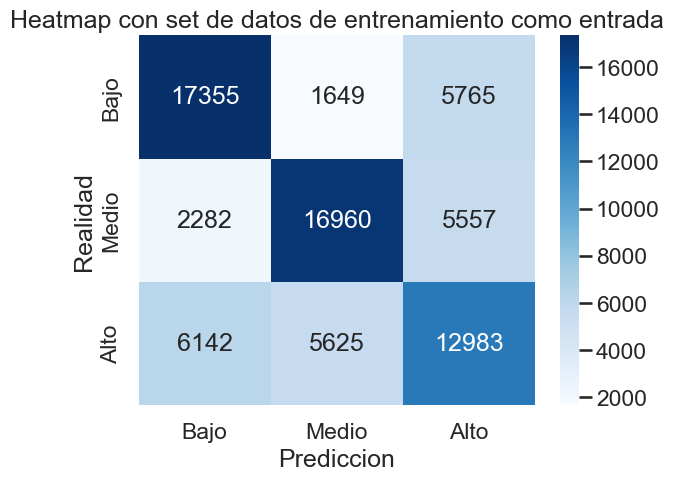

In [1830]:
y_pred_train = arbol_predictor_randomcv.predict(x_train)
labels = ['Bajo', 'Medio', 'Alto']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='micro')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')


Del heatmap anterior, podemos ver que nuestro modelo no hace la mejor prediccion para aquellas propiedades tomadas con tipo de precio Alto.  
Ahora vamos a ver como predice con nuestra entrada de test.

              precision    recall  f1-score   support

        Alto       0.65      0.66      0.65      4824
        Bajo       0.69      0.67      0.68      4986
       Medio       0.48      0.49      0.48      4785

    accuracy                           0.61     14595
   macro avg       0.61      0.60      0.60     14595
weighted avg       0.61      0.61      0.61     14595

F1-Score: 0.6054128126070573


Text(37.08333333333333, 0.5, 'Realidad')

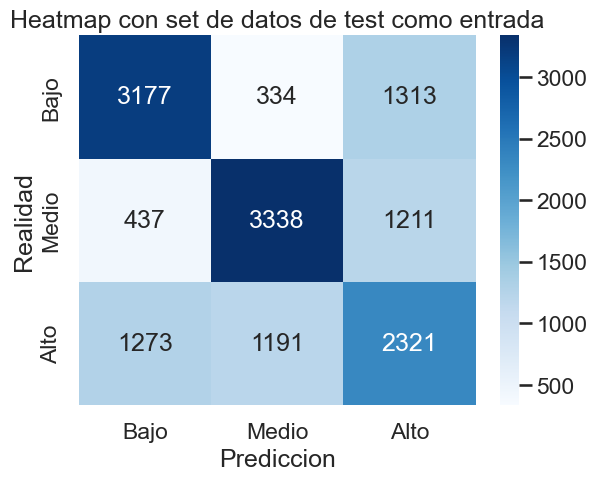

In [1831]:
y_pred_test = arbol_predictor_randomcv.predict(x_test)
labels = ['Bajo', 'Medio', 'Alto']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='micro')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Podemos observar que la metrica F1 Score nos da parecia para ambas entradas.  .
Ademas vemos que sucede lo mismo que cuando la entrada era el set de datos de entrenamiento, que a nuestro mejor modelo le cuesta predecir aquellas viviendas de tipo de precio Alto.

Ahora vamos a ver que pasa con nuestra metrica si entrenamos el arbol con distintos folds.

In [1832]:
# Spits que respeten la proporción delas clases
kfoldcv =StratifiedKFold(n_splits=20) 
 
#Creo árbol con los mejores hiperparámetros 
arbolcv=DecisionTreeClassifier()

#Selecciono métrica F1-Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='micro')

#Hago CV
resultados = cross_validate(arbolcv,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

#Selecciono el arbol con mejor performance
metricsCV=resultados['test_score']
arbol_mejor_performance_cv=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

In [1833]:
metricsCV

array([0.67168999, 0.68702906, 0.6722282 , 0.69106566, 0.68379978,
       0.68353068, 0.67491927, 0.67545748, 0.67518837, 0.68326157,
       0.6886437 , 0.69429494, 0.67572659, 0.67168999, 0.68137783,
       0.67491927, 0.67814855, 0.67007535, 0.68021534, 0.687214  ])

[Text(0.5, 1.0, 'Boxplot de F1 Score para CV'), Text(0.5, 0, 'F1 Score')]

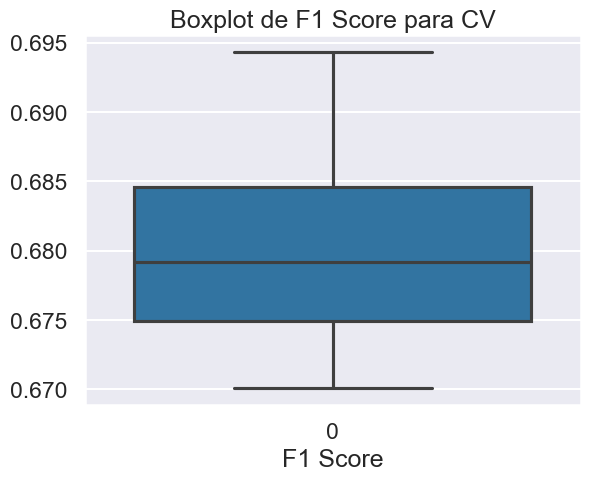

In [1834]:
sns.boxplot(metricsCV).set(title="Boxplot de F1 Score para CV",xlabel='F1 Score')

Vemos que entrenar el arbol con distintos folds es mejor que optimizar la busqueda de hiperparametros, veamoslo y apliquemoslo para la entrada de test.

In [1835]:
feat_imps = arbol_mejor_performance_cv.feature_importances_

reglas = export_text(arbol_mejor_performance_cv, feature_names=list(x_train.columns))
print(reglas)

|--- latitud <= -34.60
|   |--- barrio_Puerto Madero <= 0.50
|   |   |--- barrio_Caballito <= 0.50
|   |   |   |--- property_type_Departamento <= 0.50
|   |   |   |   |--- property_surface_total <= 100.50
|   |   |   |   |   |--- latitud <= -34.61
|   |   |   |   |   |   |--- property_surface_total <= 65.50
|   |   |   |   |   |   |   |--- property_surface_total <= 39.50
|   |   |   |   |   |   |   |   |--- latitud <= -34.65
|   |   |   |   |   |   |   |   |   |--- property_surface_covered <= 28.50
|   |   |   |   |   |   |   |   |   |   |--- property_surface_covered <= 25.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- property_surface_covered >  25.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- property_surface_covered >  28.50
|   |   |   |   |   |   |   |   |   |   |--- property_rooms <= 1.50
|   |   |   |   |   |   |   |   |   |   |

              precision    recall  f1-score   support

        Alto       0.72      0.73      0.73      4824
        Bajo       0.72      0.74      0.73      4986
       Medio       0.59      0.57      0.58      4785

    accuracy                           0.68     14595
   macro avg       0.68      0.68      0.68     14595
weighted avg       0.68      0.68      0.68     14595

F1-Score: 0.6820143884892086


Text(37.08333333333333, 0.5, 'Realidad')

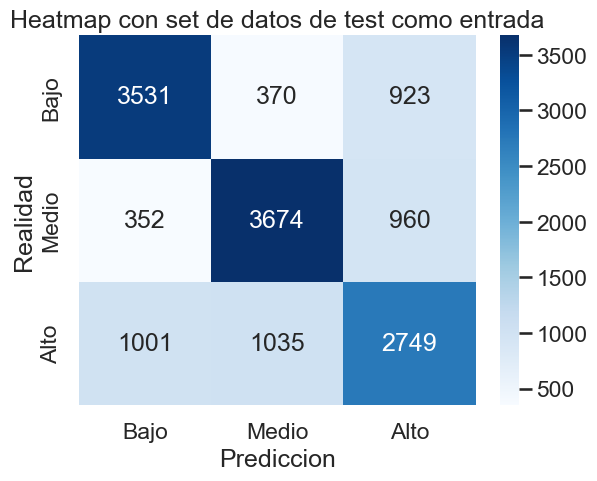

In [1836]:
y_pred_test_cv = arbol_mejor_performance_cv.predict(x_test)
labels = ['Bajo', 'Medio', 'Alto']

print(classification_report(y_test,y_pred_test_cv))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test_cv, average='micro')))

cm = confusion_matrix(y_test,y_pred_test_cv)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

De aca podemos concluir que es mas importante la entrada con la cual entreno a mi arbol que la combinacion de parametros que pueda elegir.  
Para nuestro caso es un mejor modelo el cual deja crecer el arbol hasta que sea puro, divide siempre en 2, cada hoja tiene una sola muestra y se tienen en cuenta todos los atributos.  
Vamos a graficar el mejor arbol obtenido por CrossValidation.

Y aca va recortado.

In [1838]:
plt.figure(figsize=(100,100))

tree_plot=tree.plot_tree(arbol_mejor_performance_cv,
                         max_depth=2,
                         feature_names=x_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=arbol_mejor_performance_cv.classes_)

plt.show(tree_plot)

### Modelo 2: Random Forest

Aca va explicación

In [1851]:
base_tree = RandomForestClassifier(oob_score=False, random_state=2, n_jobs=-1) 

#Cantidad de iteraciones
n = 10

#Conjunto de parámetros que queremos usar
params = {'criterion':['gini','entropy'],
            'max_features':[None, 'sqrt', 'log2'],   
            'min_samples_leaf': [1,5,10],
            'min_samples_split':[2,4,10,12,14,16],
            'n_estimators':[10,20,50]
            }

#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='micro')

#Random Search Cross Validation
randomcvRF = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, error_score='raise') 

#Buscamos los hiperparamtros que optimizan F1 Score
randomcvRF.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=2),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [2, 4, 10, 12, 14,
                                                              16],
                                        'n_estimators': [10, 20, 50]},
                   scoring=make_scorer(f1_score, average=micro))

In [1852]:
rf_predictor_randomcv=RandomForestClassifier().set_params(**randomcvRF.best_params_)
rf_predictor_randomcv.fit(x_train,y_train)

RandomForestClassifier(n_estimators=20)

In [1854]:
print(randomcvRF.best_params_)
print(randomcvRF.best_score_)

{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini'}
0.6927527046993325


              precision    recall  f1-score   support

        Alto       0.74      0.77      0.75      4824
        Bajo       0.76      0.77      0.77      4986
       Medio       0.62      0.58      0.60      4785

    accuracy                           0.71     14595
   macro avg       0.71      0.71      0.71     14595
weighted avg       0.71      0.71      0.71     14595

F1-Score: 0.7086673518328194


Text(37.08333333333333, 0.5, 'Realidad')

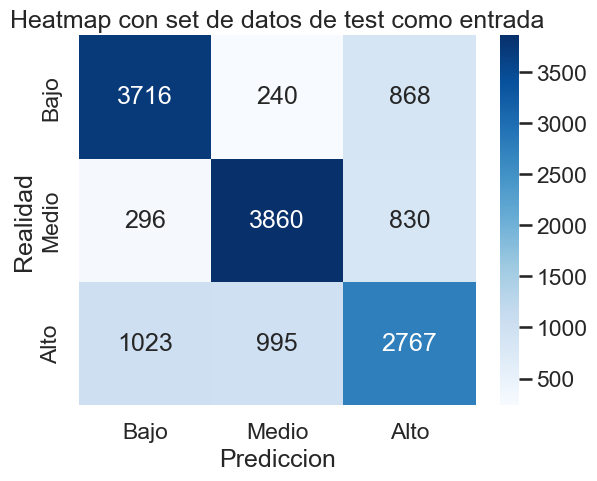

In [1856]:
y_pred_test = rf_predictor_randomcv.predict(x_test)
labels = ['Bajo', 'Medio', 'Alto']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='micro')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Vemos que RF es un mejor predictor, pero aun seguimos teniendo problemas con aquellas propiedades cuyo tipo de precio es Alto.

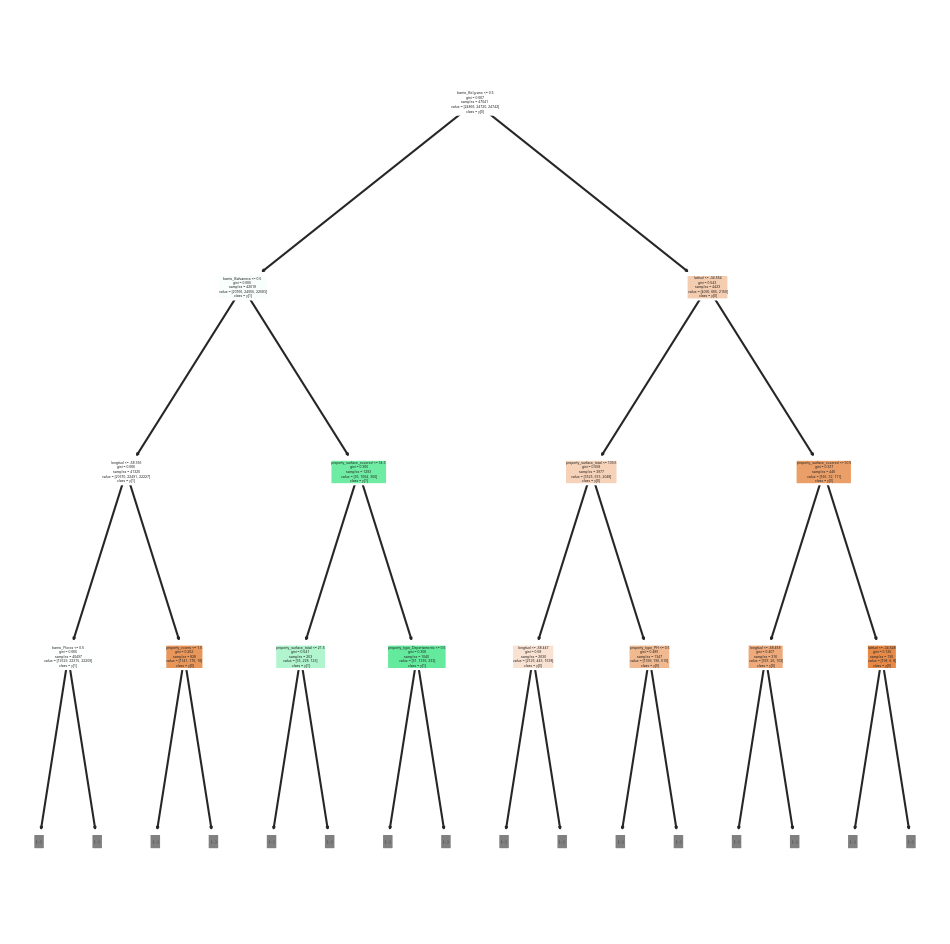

In [1861]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(rf_predictor_randomcv.estimators_[10],
                         max_depth=3,
                         feature_names=x_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)